In [1]:
import jax
import jax.numpy as jnp
import pandas as pd 
import torch
import numpy as np

import matplotlib.pyplot as plt
from IPython import display


import ott

from ott import utils
import tqdm
from ott import problems
from ott.geometry import geometry, pointcloud, costs
from ott.solvers import linear
from ott.solvers.linear import acceleration, sinkhorn, sinkhorn_lr
from ott.tools.sinkhorn_divergence import sinkhorn_divergence
from ott.problems.linear import linear_problem


    General Observations:
    - Tuning the epsilon parameter is important
    - It should not be very hard to combine our cost functions (See class MyCost)

## OT Anlaysis Class

In [ ]:
class SinkhornAnalysis():
    """
    Simple class for running some OT analyses
    """
    # Class variable for storing ot solution
    ot = None

    def __init__(self, position_data_path, frame1, frame2):
        # Extract data
        self.position_df = pd.read_csv(position_data_path, index_col=0)
        self.x = self._extract_frame(self.position_df,frame1)
        self.y = self._extract_frame(self.position_df,frame2)

        # Standardize data
        self.x = self._standardize(x)
        self.y = self._standardize(y)

    def _extract_frame(self, df, frame, normlize="Z_score"):
        x = jnp.array(df.iloc[::2,frame])
        y = jnp.array(df.iloc[1::2,frame])
        pos = jnp.array([x,y]).T
        return pos

    def _standardize(self, x):
        mean = jnp.mean(x)
        std = jnp.std(x)
        x_stand = (x-mean)/std
        return x_stand

    def plot_data(self):
        x_args = {"s": 10, "label": r"source $x$", "marker": "s", "edgecolor": "k"}
        y_args = {"s": 10, "label": r"target $y$", "edgecolor": "k", "alpha": 0.75}
        plt.figure(figsize=(9, 6))
        plt.scatter(self.x[:, 0], self.x[:, 1], **x_args)
        plt.scatter(self.y[:, 0], self.y[:, 1], **y_args)
        plt.legend()
        plt.show()

    def solve_ot(self, epsilon=0.01, cost_fn=None, low_rank=False, verbose=True):
        # Define Geometry
        geom = pointcloud.PointCloud(self.x, self.y, epsilon=epsilon, cost_fn=cost_fn) # Eucledian distance is default (if cost_fn=None)

        # Define Problem
        ot_prob = linear_problem.LinearProblem(geom)
 
        # Solve Problem       
        with tqdm.tqdm() as pbar:
            progress_fn = utils.tqdm_progress_fn(pbar)

            if low_rank == True:
                solve_fn = sinkhorn_lr.LRSinkhorn(rank=int(min(len(x), len(y)) / 2), progress_fn=progress_fn)
            else:
                solve_fn = sinkhorn.Sinkhorn(progress_fn=progress_fn)
                
            self.ot = jax.jit(solve_fn)(ot_prob)

        if verbose:
            print(
            "\nSinkhorn has converged: ",
            self.ot.converged,
            "\n",
            "Error upon last iteration: ",
            self.ot.errors[(self.ot.errors > -1)][-1],
            "\n",
            "Sinkhorn required ",
            jnp.sum(self.ot.errors > -1),
            " iterations to converge. \n",
            "Entropy regularized OT cost: ",
            self.ot.reg_ot_cost,
            "\n",
            "OT cost (without entropy): ",
            jnp.sum(self.ot.matrix * self.ot.geom.cost_matrix),
            )

        return self.ot
     
    def _get_bin_ot_matrix(self):
        bin_ot_mat = np.zeros_like(self.ot.matrix)
        bin_ot_mat[np.arange(len(self.ot.matrix)), self.ot.matrix.argmax(1)] = 1
        return bin_ot_mat

    def best_k_score(self, k):
        max_mat = np.zeros_like(self.ot.matrix)

        # Only keep maximal entries (choices of algorithm)
        max_mat[np.arange(len(self.ot.matrix)), self.ot.matrix.argmax(1)] = self.ot.matrix.max(1)

        # Identify k largest element
        k_largest_elem = np.sort(max_mat.max(1))[-k]

        # Filter all choices where the value is lower than the k-largest
        max_mat[max_mat < k_largest_elem] = 0

        # Make matrix binary
        max_mat[max_mat > 0] = 1 

        # Return the normalized score
        score = np.diagonal(max_mat).sum()/k
        return score

    def get_bin_accuracy(self):
        return self.best_k_score(self.ot.matrix, k=len(np.diagonal(self.ot.matrix)))

In [ ]:
@jax.tree_util.register_pytree_node_class
class MyCost(costs.CostFn):
    """An unusual cost function."""
    def __init__(self,alpha=2,beta=2):
        self.alpha=alpha
        self.beta=beta

    def pairwise(self, x, y):
        return self.pairwise_dim1(x,y)
    
    def pairwise_dim1(self, x, y):
        return (x[0]-y[0])**self.beta
    
    def pairwise_dim2(self, x, y):
        return (x[1]-y[1])**self.alpha

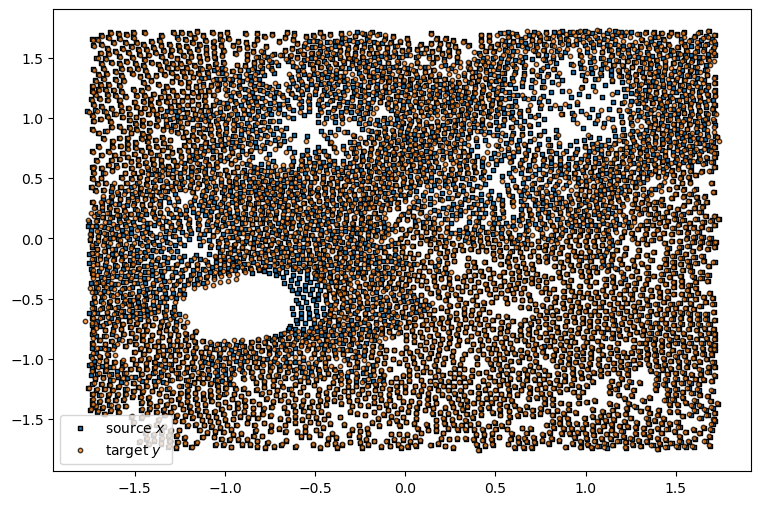

In [ ]:
data_path = "ground_truth_generation/ot_data/L1_A0_R1_D1_M1_5000_3/droplet_positions.csv"
ot_analysis = SinkhornAnalysis(data_path, 1, 2)
ot_analysis.plot_data()

In [ ]:
#ot = ot_analysis.solve_ot(0.01, MyCost(2,2), low_rank=False, verbose=True) #With custom cost
ot = ot_analysis.solve_ot(epsilon=0.01, cost_fn=None, low_rank=False, verbose=True)

  8%|▊         | 17/200 [00:25<04:34,  1.50s/it, error: 9.773429e-04]



Sinkhorn has converged:  True 
 Error upon last iteration:  0.000977343 
 Sinkhorn required  17  iterations to converge. 
 Entropy regularized OT cost:  0.060051057 
 OT cost (without entropy):  0.010310734


In [ ]:
score_best100 = ot_analysis.best_k_score(100)
score_best500 = ot_analysis.best_k_score(500)
score_best1000 = ot_analysis.best_k_score(1000)
score_best3000 = ot_analysis.best_k_score(3000)
score_best5000 = ot_analysis.best_k_score(5000)

print(f"Best 100: {score_best100}\n"+
      f"Best 500: {score_best500}\n"+
      f"Best 1000: {score_best1000}\n"+
      f"Best 3000: {score_best3000}\n"+
      f"Best 5000: {score_best5000}\n")

Best 100: 0.99
Best 500: 0.804
Best 1000: 0.819
Best 3000: 0.8726666666666667
Best 5000: 0.7324

